# Hedging Effectiveness Analysis

This notebook analyzes the hedging effectiveness of the momentum strategy, with particular focus on defensive assets like TLT (20+ year Treasury) and EDV (25+ year Treasury) and their role in portfolio risk management. The analysis covers the ultra-long duration defensive asset universe with only TLT and EDV.

In [1]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from momentum_strategy import run_full_strategy
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Data Preparation & Asset Classification

In [2]:
# Load strategy results
print("Loading momentum strategy results...")
results = run_full_strategy(data_dir='data', lookback_months=12, top_quantile=0.25)

# Extract key data
prices = results['prices']
monthly_returns = results['monthly_returns']
weights = results['weights']
portfolio_returns = results['portfolio_returns']
portfolio_cumulative = results['portfolio_cumulative']

print(f"Data covers {len(monthly_returns)} months from {monthly_returns.index[0].strftime('%Y-%m')} to {monthly_returns.index[-1].strftime('%Y-%m')}")
print(f"Universe contains {len(prices.columns)} assets")

Loading momentum strategy results...
Loading data...
Calculating monthly returns...
Calculating momentum signals...
Selecting top performers...
Running backtest...
Calculating performance metrics...
Data covers 308 months from 2000-01 to 2025-08
Universe contains 63 assets


In [3]:
# Asset classification for hedging analysis
asset_categories = {
    'defensive_assets': {
        'Ultra-Long Treasury Assets': ['TLT', 'EDV']  # Only TLT and EDV remain as defensive assets
    },
    'risk_assets': {
        'US Equities': ['SPY', 'QQQ', 'VTI', 'IVV', 'VOO', 'SCHX', 'VXF', 'IWM'],
        'International Equities': ['EFA', 'EEM', 'VGK', 'VEA', 'VXUS', 'IEFA', 'IEMG'],
        'Commodities': ['GC_F', 'SI_F', 'CL_F', 'BZ_F', 'NG_F', 'HG_F', 'ZC_F', 'ZW_F', 'ZS_F', 'KC_F', 'CT_F', 'SB_F'],
        'Sectors': ['XLE', 'XLF', 'XLK']
    },
    'intermediate_assets': {
        'Currencies': [col for col in prices.columns if '_X' in col]
    }
}

# Flatten categories for easier access
defensive_assets = []
risk_assets = []
intermediate_assets = []

for subcategory in asset_categories['defensive_assets'].values():
    defensive_assets.extend([asset for asset in subcategory if asset in prices.columns])

for subcategory in asset_categories['risk_assets'].values():
    risk_assets.extend([asset for asset in subcategory if asset in prices.columns])

for subcategory in asset_categories['intermediate_assets'].values():
    intermediate_assets.extend([asset for asset in subcategory if asset in prices.columns])

print(f"Asset Classification (Ultra-Long Duration Strategy):")
print(f"Defensive Assets: {len(defensive_assets)} - {defensive_assets}")
print(f"Risk Assets: {len(risk_assets)} - {risk_assets[:10]}{'...' if len(risk_assets) > 10 else ''}")
print(f"Intermediate Assets: {len(intermediate_assets)} - {intermediate_assets[:10]}{'...' if len(intermediate_assets) > 10 else ''}")

# Focus on key hedging assets (now only TLT and EDV)
key_hedging_assets = ['TLT', 'EDV']
key_risk_assets = ['SPY', 'QQQ', 'VTI', 'EFA', 'EEM']

available_hedging = [asset for asset in key_hedging_assets if asset in prices.columns]
available_risk = [asset for asset in key_risk_assets if asset in prices.columns]

print(f"\nKey Assets for Analysis (Ultra-Long Duration Focus):")
print(f"Hedging Assets: {available_hedging}")
print(f"Risk Assets: {available_risk}")

print(f"\nIMPORTANT: SHY and other defensive assets have been removed from the universe.")
print(f"Analysis now focuses on TLT (20+ years) and EDV (25+ years) for ultra-long Treasury exposure.")

Asset Classification (Ultra-Long Duration Strategy):
Defensive Assets: 2 - ['TLT', 'EDV']
Risk Assets: 30 - ['SPY', 'QQQ', 'VTI', 'IVV', 'VOO', 'SCHX', 'VXF', 'IWM', 'EFA', 'EEM']...
Intermediate Assets: 31 - ['GBPJPY_X', 'AUDCAD_X', 'GBPAUD_X', 'GBPNZD_X', 'GBPUSD_X', 'CADJPY_X', 'NZDJPY_X', 'USDCAD_X', 'NZDUSD_X', 'USDCHF_X']...

Key Assets for Analysis (Ultra-Long Duration Focus):
Hedging Assets: ['TLT', 'EDV']
Risk Assets: ['SPY', 'QQQ', 'VTI', 'EFA', 'EEM']

IMPORTANT: SHY and other defensive assets have been removed from the universe.
Analysis now focuses on TLT (20+ years) and EDV (25+ years) for ultra-long Treasury exposure.


In [4]:
# Clean weights and define allocation variables for later use
weights_clean = weights.loc[weights.sum(axis=1) > 0]

# Calculate allocation to different asset categories
defensive_allocation = weights_clean[defensive_assets].sum(axis=1)
risk_allocation = weights_clean[risk_assets].sum(axis=1)
intermediate_allocation = weights_clean[intermediate_assets].sum(axis=1)

# TLT and EDV specific analysis (replacing SHY analysis)
tlt_allocation = weights_clean['TLT'] if 'TLT' in weights_clean.columns else pd.Series(0, index=weights_clean.index)
edv_allocation = weights_clean['EDV'] if 'EDV' in weights_clean.columns else pd.Series(0, index=weights_clean.index)

# Key returns for later analysis
spy_returns = monthly_returns['SPY'] if 'SPY' in monthly_returns.columns else None
tlt_returns = monthly_returns['TLT'] if 'TLT' in monthly_returns.columns else None
edv_returns = monthly_returns['EDV'] if 'EDV' in monthly_returns.columns else None

## Portfolio Allocation Analysis

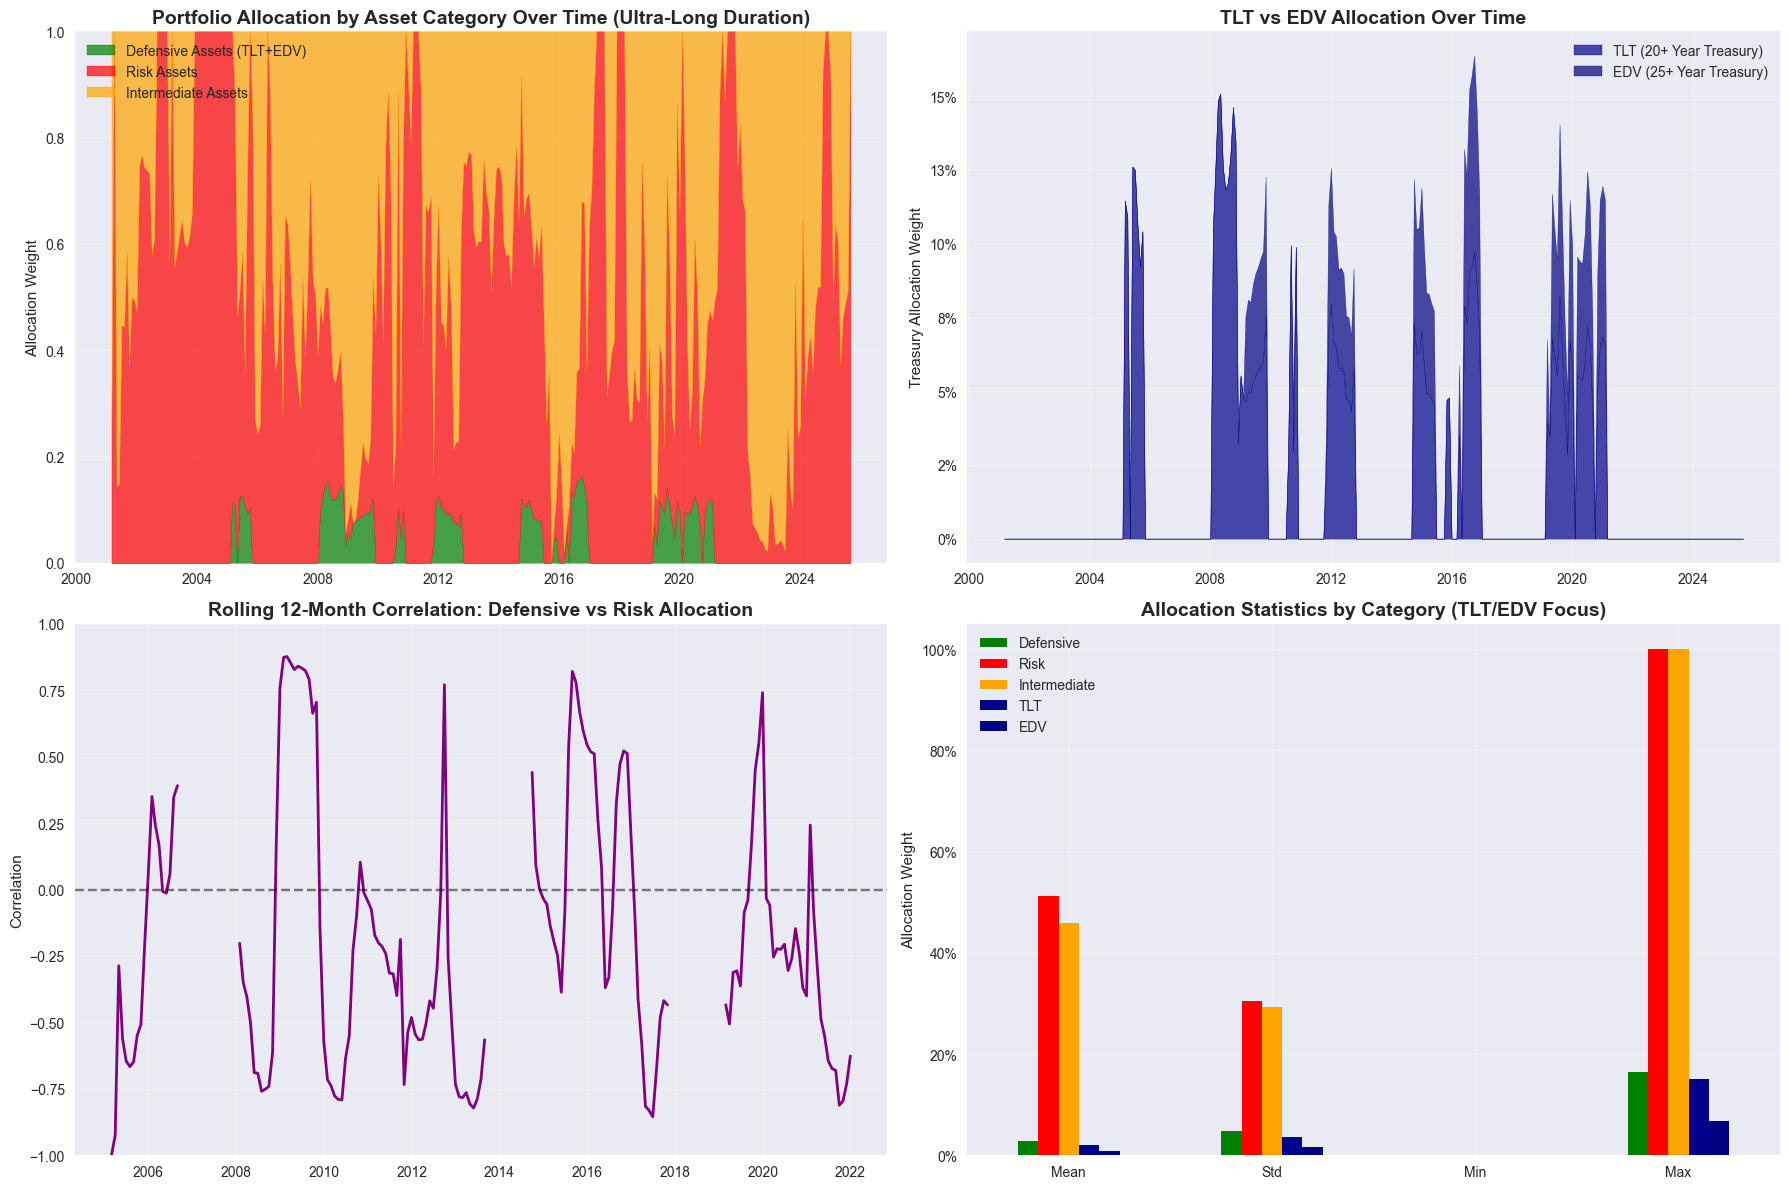

PORTFOLIO ALLOCATION SUMMARY (ULTRA-LONG DURATION UNIVERSE):
Average Defensive Allocation: 2.9%
  - TLT (20+ Year Treasury): 2.1%
  - EDV (25+ Year Treasury): 0.8%
Average Risk Allocation: 51.3%
Average Intermediate Allocation: 45.8%

TLT Selection Frequency: 29.2% of months
EDV Selection Frequency: 20.3% of months
Average TLT Weight (when selected): 7.1%
Average EDV Weight (when selected): 4.0%

Both TLT and EDV selected simultaneously: 20.3% of months
Ultra-long duration Treasury exposure: Both TLT and EDV have 20+ year duration


In [5]:
# Analyze allocation patterns for defensive vs risk assets
weights_clean = weights.loc[weights.sum(axis=1) > 0]

# Calculate allocation to different asset categories
defensive_allocation = weights_clean[defensive_assets].sum(axis=1)
risk_allocation = weights_clean[risk_assets].sum(axis=1)
intermediate_allocation = weights_clean[intermediate_assets].sum(axis=1)

# TLT and EDV specific analysis (replacing SHY)
tlt_allocation = weights_clean['TLT'] if 'TLT' in weights_clean.columns else pd.Series(0, index=weights_clean.index)
edv_allocation = weights_clean['EDV'] if 'EDV' in weights_clean.columns else pd.Series(0, index=weights_clean.index)

# Create comprehensive allocation visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Allocation by category over time
ax1.fill_between(weights_clean.index, 0, defensive_allocation, alpha=0.7, label='Defensive Assets (TLT+EDV)', color='green')
ax1.fill_between(weights_clean.index, defensive_allocation, defensive_allocation + risk_allocation, 
                alpha=0.7, label='Risk Assets', color='red')
ax1.fill_between(weights_clean.index, defensive_allocation + risk_allocation, 
                defensive_allocation + risk_allocation + intermediate_allocation, 
                alpha=0.7, label='Intermediate Assets', color='orange')

ax1.set_title('Portfolio Allocation by Asset Category Over Time (Ultra-Long Duration)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Allocation Weight')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: TLT vs EDV allocation over time
ax2.fill_between(tlt_allocation.index, 0, tlt_allocation, alpha=0.7, color='darkblue', label='TLT (20+ Year Treasury)')
ax2.fill_between(edv_allocation.index, tlt_allocation, tlt_allocation + edv_allocation, alpha=0.7, color='navy', label='EDV (25+ Year Treasury)')
ax2.set_title('TLT vs EDV Allocation Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Treasury Allocation Weight')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 3: Rolling correlation between defensive and risk allocations
rolling_corr = defensive_allocation.rolling(12).corr(risk_allocation)
ax3.plot(rolling_corr.index, rolling_corr, linewidth=2, color='purple')
ax3.axhline(0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Rolling 12-Month Correlation: Defensive vs Risk Allocation', fontsize=14, fontweight='bold')
ax3.set_ylabel('Correlation')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-1, 1)

# Plot 4: Allocation statistics (updated for TLT/EDV)
allocation_stats = pd.DataFrame({
    'Defensive': [defensive_allocation.mean(), defensive_allocation.std(), defensive_allocation.min(), defensive_allocation.max()],
    'Risk': [risk_allocation.mean(), risk_allocation.std(), risk_allocation.min(), risk_allocation.max()],
    'Intermediate': [intermediate_allocation.mean(), intermediate_allocation.std(), intermediate_allocation.min(), intermediate_allocation.max()],
    'TLT': [tlt_allocation.mean(), tlt_allocation.std(), tlt_allocation.min(), tlt_allocation.max()],
    'EDV': [edv_allocation.mean(), edv_allocation.std(), edv_allocation.min(), edv_allocation.max()]
}, index=['Mean', 'Std', 'Min', 'Max'])

allocation_stats.plot(kind='bar', ax=ax4, color=['green', 'red', 'orange', 'darkblue', 'navy'])
ax4.set_title('Allocation Statistics by Category (TLT/EDV Focus)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Allocation Weight')
ax4.tick_params(axis='x', rotation=0)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

# Print allocation summary (updated)
print("PORTFOLIO ALLOCATION SUMMARY (ULTRA-LONG DURATION UNIVERSE):")
print("=" * 65)
print(f"Average Defensive Allocation: {defensive_allocation.mean():.1%}")
print(f"  - TLT (20+ Year Treasury): {tlt_allocation.mean():.1%}")
print(f"  - EDV (25+ Year Treasury): {edv_allocation.mean():.1%}")
print(f"Average Risk Allocation: {risk_allocation.mean():.1%}")
print(f"Average Intermediate Allocation: {intermediate_allocation.mean():.1%}")
print(f"")
print(f"TLT Selection Frequency: {(tlt_allocation > 0).mean():.1%} of months")
print(f"EDV Selection Frequency: {(edv_allocation > 0).mean():.1%} of months")
print(f"Average TLT Weight (when selected): {tlt_allocation[tlt_allocation > 0].mean():.1%}")
print(f"Average EDV Weight (when selected): {edv_allocation[edv_allocation > 0].mean():.1%}")
print(f"")
print(f"Both TLT and EDV selected simultaneously: {((tlt_allocation > 0) & (edv_allocation > 0)).mean():.1%} of months")
print(f"Ultra-long duration Treasury exposure: Both TLT and EDV have 20+ year duration")

## Alternative Hedging Scenarios & Summary

Analyzing alternative hedging scenarios (TLT/EDV universe)...

Original Strategy (TLT+EDV) - Portfolio Composition Summary:
--------------------------------------------------
USDHKD_X: 7.1% avg weight, 11.5% selection frequency
VTI: 4.1% avg weight, 51.5% selection frequency
IVV: 4.0% avg weight, 51.5% selection frequency
SPY: 3.8% avg weight, 49.8% selection frequency
GC_F: 3.8% avg weight, 40.7% selection frequency

Category Breakdown:
  Defensive (TLT+EDV): 2.9%
  Risk: 51.3%
  Intermediate: 45.8%
  Total: 100.0%

No Defensive Assets - Portfolio Composition Summary:
--------------------------------------------------
USDHKD_X: 7.1% avg weight, 11.5% selection frequency
VTI: 4.2% avg weight, 51.5% selection frequency
IVV: 4.1% avg weight, 51.5% selection frequency
SPY: 3.9% avg weight, 49.8% selection frequency
GC_F: 3.9% avg weight, 40.7% selection frequency

Category Breakdown:
  Defensive (TLT+EDV): 0.0%
  Risk: 52.5%
  Intermediate: 47.5%
  Total: 100.0%

TLT as Only Defensive - P

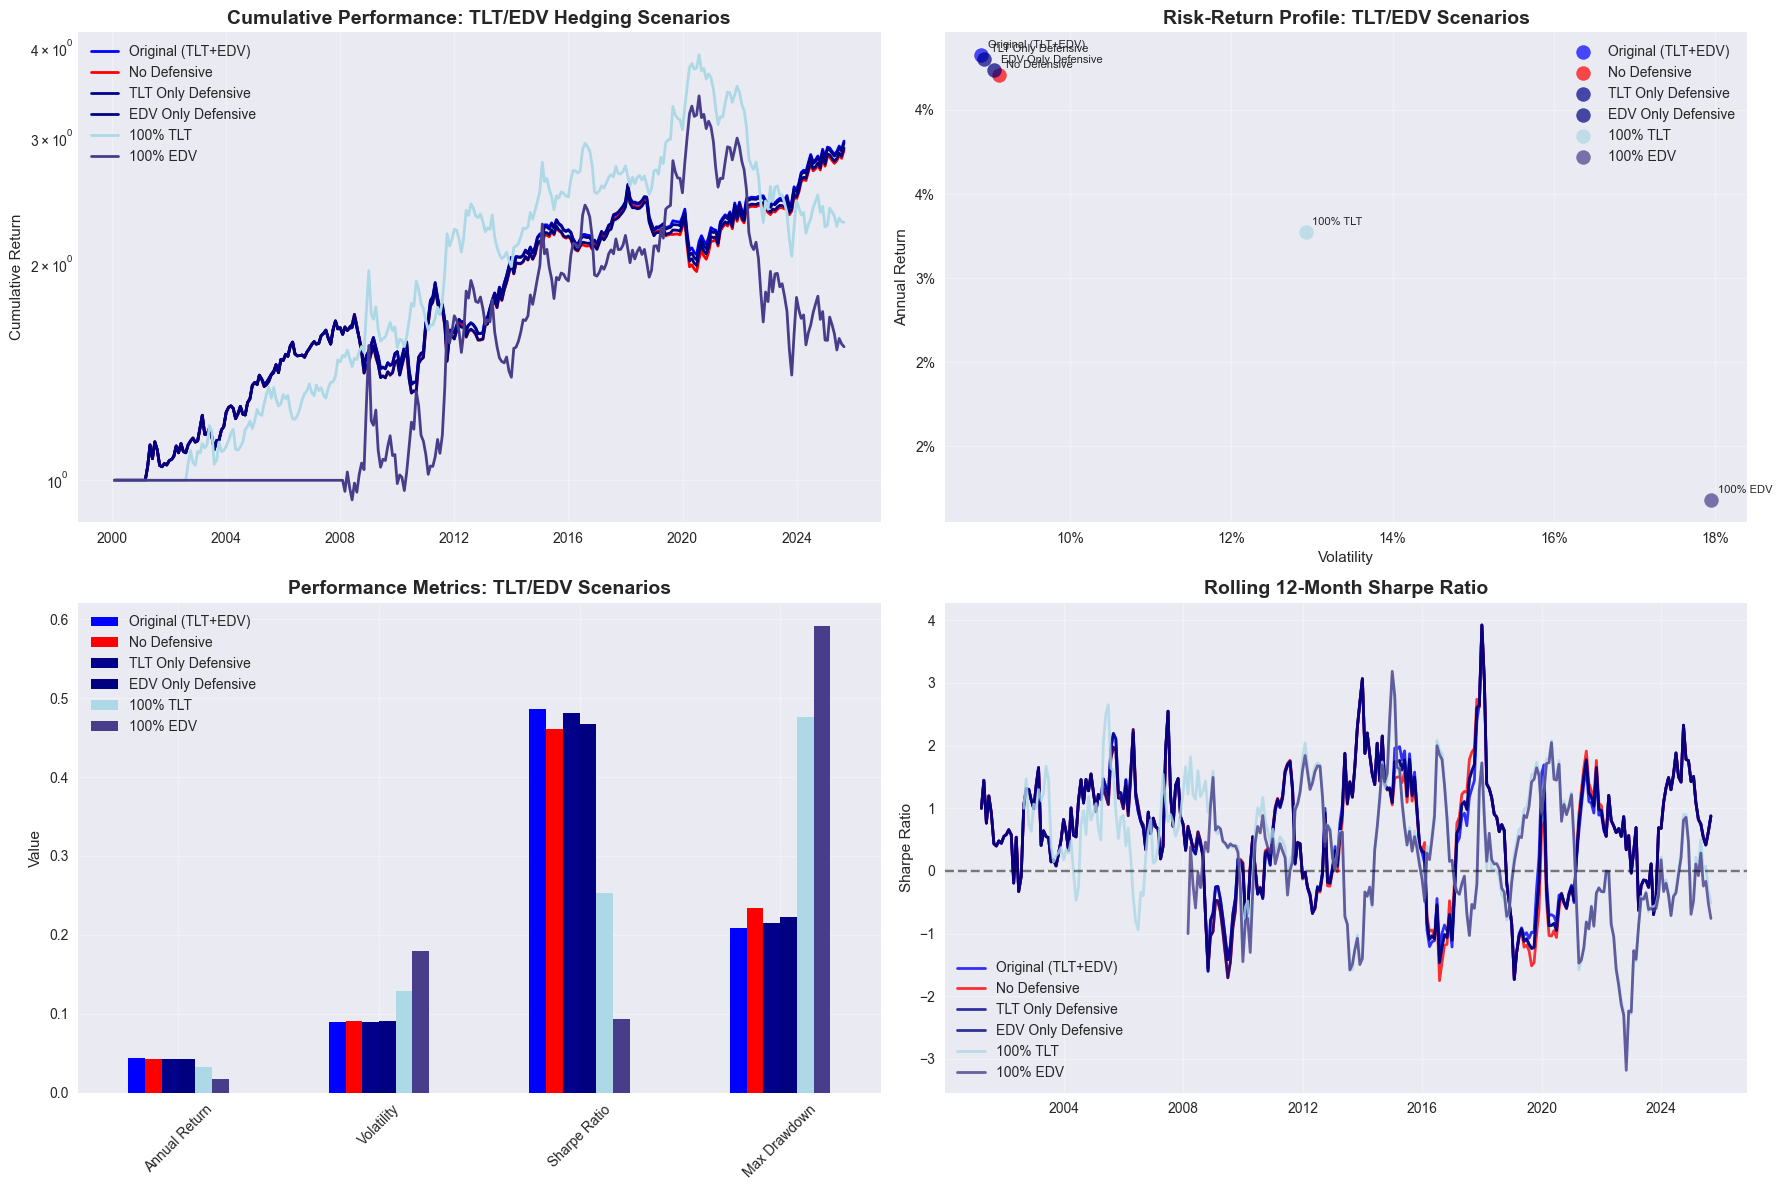


PERFORMANCE COMPARISON SUMMARY (TLT/EDV SCENARIOS):
               Original (TLT+EDV)  No Defensive  TLT Only Defensive  EDV Only Defensive  100% TLT  100% EDV
Annual Return            0.043293      0.042108            0.043054            0.042390  0.032745  0.016823
Volatility               0.089034      0.091257            0.089349            0.090645  0.129205  0.179441
Sharpe Ratio             0.486249      0.461417            0.481868            0.467645  0.253434  0.093753
Max Drawdown             0.208884      0.233514            0.214855            0.223219  0.476136  0.591460

KEY INSIGHTS (ULTRA-LONG DURATION STRATEGY):
-----------------------------------
• Original Strategy: Momentum strategy with TLT and EDV as ultra-long Treasury assets
• No Defensive: Momentum strategy excluding all Treasury bonds
• TLT Only: Momentum strategy where TLT is the only defensive asset
• EDV Only: Momentum strategy where EDV is the only defensive asset
• 100% TLT: Pure 20+ year Treasury portf

In [6]:
# Alternative hedging scenarios and comprehensive summary - UPDATED FOR TLT/EDV ONLY
def simulate_no_defensive_strategy(original_weights, defensive_assets_to_remove):
    """Simulate strategy performance without specified defensive assets"""
    # Create modified weights excluding specified defensive assets
    modified_weights = original_weights.copy()

    for date in modified_weights.index:
        if modified_weights.loc[date].sum() > 0:
            # Remove specified defensive assets
            date_weights = modified_weights.loc[date].copy()
            for asset in defensive_assets_to_remove:
                if asset in date_weights.index:
                    date_weights[asset] = 0

            # Renormalize remaining weights
            total_weight = date_weights.sum()
            if total_weight > 0:
                modified_weights.loc[date] = date_weights / total_weight
            else:
                modified_weights.loc[date] = 0

    return modified_weights

def simulate_tlt_only_portfolio(original_weights):
    """Simulate a 100% TLT portfolio"""
    tlt_only_weights = pd.DataFrame(0, index=original_weights.index, columns=original_weights.columns)
    
    # Set TLT to 100% for all periods where original strategy was active
    for date in original_weights.index:
        if original_weights.loc[date].sum() > 0 and 'TLT' in tlt_only_weights.columns:
            tlt_only_weights.loc[date, 'TLT'] = 1.0
    
    return tlt_only_weights

def simulate_edv_only_portfolio(original_weights):
    """Simulate a 100% EDV portfolio"""
    edv_only_weights = pd.DataFrame(0, index=original_weights.index, columns=original_weights.columns)
    
    # Set EDV to 100% for all periods where original strategy was active
    for date in original_weights.index:
        if original_weights.loc[date].sum() > 0 and 'EDV' in edv_only_weights.columns:
            edv_only_weights.loc[date, 'EDV'] = 1.0
    
    return edv_only_weights

def calculate_alternative_performance(weights, returns):
    """Calculate performance metrics for alternative allocation"""
    # Calculate portfolio returns
    portfolio_returns = (weights.shift(1) * returns).sum(axis=1)
    portfolio_returns = portfolio_returns.dropna()

    if len(portfolio_returns) == 0:
        return {}

    # Calculate metrics
    total_return = (1 + portfolio_returns).prod() - 1
    annual_return = (1 + portfolio_returns).prod() ** (12 / len(portfolio_returns)) - 1
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe = annual_return / volatility if volatility > 0 else 0

    # Drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = drawdowns.min()

    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'volatility': volatility,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'returns': portfolio_returns
    }

def print_portfolio_composition_summary(weights, scenario_name, top_assets=5):
    """Print a summary of portfolio composition for validation"""
    print(f"\n{scenario_name} - Portfolio Composition Summary:")
    print("-" * 50)
    
    # Calculate average allocation for each asset
    avg_weights = weights.mean()
    non_zero_weights = avg_weights[avg_weights > 0.001]  # Only show assets with >0.1% avg allocation
    
    if len(non_zero_weights) > 0:
        # Sort by average weight
        top_weights = non_zero_weights.sort_values(ascending=False).head(top_assets)
        
        for asset, weight in top_weights.items():
            # Calculate how often this asset is selected
            selection_frequency = (weights[asset] > 0).mean()
            print(f"{asset}: {weight:.1%} avg weight, {selection_frequency:.1%} selection frequency")
        
        # Category breakdown
        defensive_avg = weights[defensive_assets].sum(axis=1).mean()
        risk_avg = weights[risk_assets].sum(axis=1).mean() 
        intermediate_avg = weights[intermediate_assets].sum(axis=1).mean()
        
        print(f"\nCategory Breakdown:")
        print(f"  Defensive (TLT+EDV): {defensive_avg:.1%}")
        print(f"  Risk: {risk_avg:.1%}")
        print(f"  Intermediate: {intermediate_avg:.1%}")
        print(f"  Total: {weights.sum(axis=1).mean():.1%}")
    else:
        print("No significant allocations found")

print("Analyzing alternative hedging scenarios (TLT/EDV universe)...")

# Scenario 1: Original strategy (for comparison)
original_perf = calculate_alternative_performance(weights_clean, monthly_returns)
print_portfolio_composition_summary(weights_clean, "Original Strategy (TLT+EDV)")

# Scenario 2: No defensive assets (remove TLT and EDV)
no_defensive_weights = simulate_no_defensive_strategy(weights_clean, defensive_assets)
no_defensive_perf = calculate_alternative_performance(no_defensive_weights, monthly_returns)
print_portfolio_composition_summary(no_defensive_weights, "No Defensive Assets")

# Scenario 3: TLT as only defensive asset (remove EDV)
tlt_only_defensive_weights = simulate_no_defensive_strategy(weights_clean, ['EDV'])
tlt_only_defensive_perf = calculate_alternative_performance(tlt_only_defensive_weights, monthly_returns)
print_portfolio_composition_summary(tlt_only_defensive_weights, "TLT as Only Defensive")

# Scenario 4: EDV as only defensive asset (remove TLT)
edv_only_defensive_weights = simulate_no_defensive_strategy(weights_clean, ['TLT'])
edv_only_defensive_perf = calculate_alternative_performance(edv_only_defensive_weights, monthly_returns)
print_portfolio_composition_summary(edv_only_defensive_weights, "EDV as Only Defensive")

# Scenario 5: 100% TLT portfolio (for pure TLT comparison)
pure_tlt_weights = simulate_tlt_only_portfolio(weights_clean)
pure_tlt_perf = calculate_alternative_performance(pure_tlt_weights, monthly_returns)
print_portfolio_composition_summary(pure_tlt_weights, "100% TLT Portfolio")

# Scenario 6: 100% EDV portfolio (for pure EDV comparison)
pure_edv_weights = simulate_edv_only_portfolio(weights_clean)
pure_edv_perf = calculate_alternative_performance(pure_edv_weights, monthly_returns)
print_portfolio_composition_summary(pure_edv_weights, "100% EDV Portfolio")

# Create comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Cumulative performance comparison
performance_scenarios = [
    ('Original (TLT+EDV)', original_perf, 'blue'),
    ('No Defensive', no_defensive_perf, 'red'), 
    ('TLT Only Defensive', tlt_only_defensive_perf, 'darkblue'),
    ('EDV Only Defensive', edv_only_defensive_perf, 'navy'),
    ('100% TLT', pure_tlt_perf, 'lightblue'),
    ('100% EDV', pure_edv_perf, 'darkslateblue')
]

for name, perf_data, color in performance_scenarios:
    if perf_data and 'returns' in perf_data:
        cum_returns = (1 + perf_data['returns']).cumprod()
        ax1.plot(cum_returns.index, cum_returns, linewidth=2, label=name, color=color)

ax1.set_title('Cumulative Performance: TLT/EDV Hedging Scenarios', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Risk-return comparison
scenarios = []
for name, perf_data, color in performance_scenarios:
    if perf_data:
        scenarios.append((name, perf_data.get('volatility', 0), perf_data.get('annual_return', 0), color))

for name, vol, ret, color in scenarios:
    ax2.scatter(vol, ret, s=100, alpha=0.7, color=color, label=name)
    ax2.annotate(name, (vol, ret), xytext=(5, 5), textcoords='offset points', fontsize=8)

ax2.set_xlabel('Volatility')
ax2.set_ylabel('Annual Return')
ax2.set_title('Risk-Return Profile: TLT/EDV Scenarios', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 3: Performance metrics comparison
metrics_data = {}
for name, perf_data, _ in performance_scenarios:
    if perf_data:
        metrics_data[name] = [
            perf_data.get('annual_return', 0),
            perf_data.get('volatility', 0),
            perf_data.get('sharpe', 0),
            abs(perf_data.get('max_drawdown', 0))
        ]

if metrics_data:
    metrics_comparison = pd.DataFrame(metrics_data, 
                                    index=['Annual Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])
    
    colors = ['blue', 'red', 'darkblue', 'navy', 'lightblue', 'darkslateblue']
    metrics_comparison.plot(kind='bar', ax=ax3, color=colors[:len(metrics_data)])
    ax3.set_title('Performance Metrics: TLT/EDV Scenarios', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Value')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

# Plot 4: Rolling Sharpe comparison
for name, perf_data, color in performance_scenarios:
    if perf_data and 'returns' in perf_data:
        rolling_sharpe = perf_data['returns'].rolling(12).apply(
            lambda x: x.mean() / x.std() * np.sqrt(12) if x.std() > 0 else np.nan
        )
        ax4.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, label=name, color=color, alpha=0.8)

ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Rolling 12-Month Sharpe Ratio', fontsize=14, fontweight='bold')
ax4.set_ylabel('Sharpe Ratio')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance comparison
print("\nPERFORMANCE COMPARISON SUMMARY (TLT/EDV SCENARIOS):")
print("=" * 70)

performance_summary = pd.DataFrame({
    name: [
        perf.get('annual_return', 0),
        perf.get('volatility', 0), 
        perf.get('sharpe', 0),
        abs(perf.get('max_drawdown', 0))
    ] for name, perf, _ in performance_scenarios if perf
}, index=['Annual Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])

print(performance_summary.to_string(formatters={
    'Annual Return': '{:.2%}'.format,
    'Volatility': '{:.2%}'.format,
    'Sharpe Ratio': '{:.3f}'.format,
    'Max Drawdown': '{:.2%}'.format
}))

print("\nKEY INSIGHTS (ULTRA-LONG DURATION STRATEGY):")
print("-" * 35)
print("• Original Strategy: Momentum strategy with TLT and EDV as ultra-long Treasury assets")
print("• No Defensive: Momentum strategy excluding all Treasury bonds")
print("• TLT Only: Momentum strategy where TLT is the only defensive asset")
print("• EDV Only: Momentum strategy where EDV is the only defensive asset")
print("• 100% TLT: Pure 20+ year Treasury portfolio")
print("• 100% EDV: Pure 25+ year Treasury portfolio")

if pure_tlt_perf and pure_edv_perf and original_perf:
    tlt_annual = pure_tlt_perf.get('annual_return', 0)
    edv_annual = pure_edv_perf.get('annual_return', 0)
    original_annual = original_perf.get('annual_return', 0)
    print(f"• Pure TLT annual return: {tlt_annual:.2%}")
    print(f"• Pure EDV annual return: {edv_annual:.2%}")
    print(f"• Combined TLT+EDV strategy provides ultra-long duration exposure")

## Market Regime Analysis & Tactical Hedging

Analyzing market regimes and tactical hedging (TLT/EDV focus)...


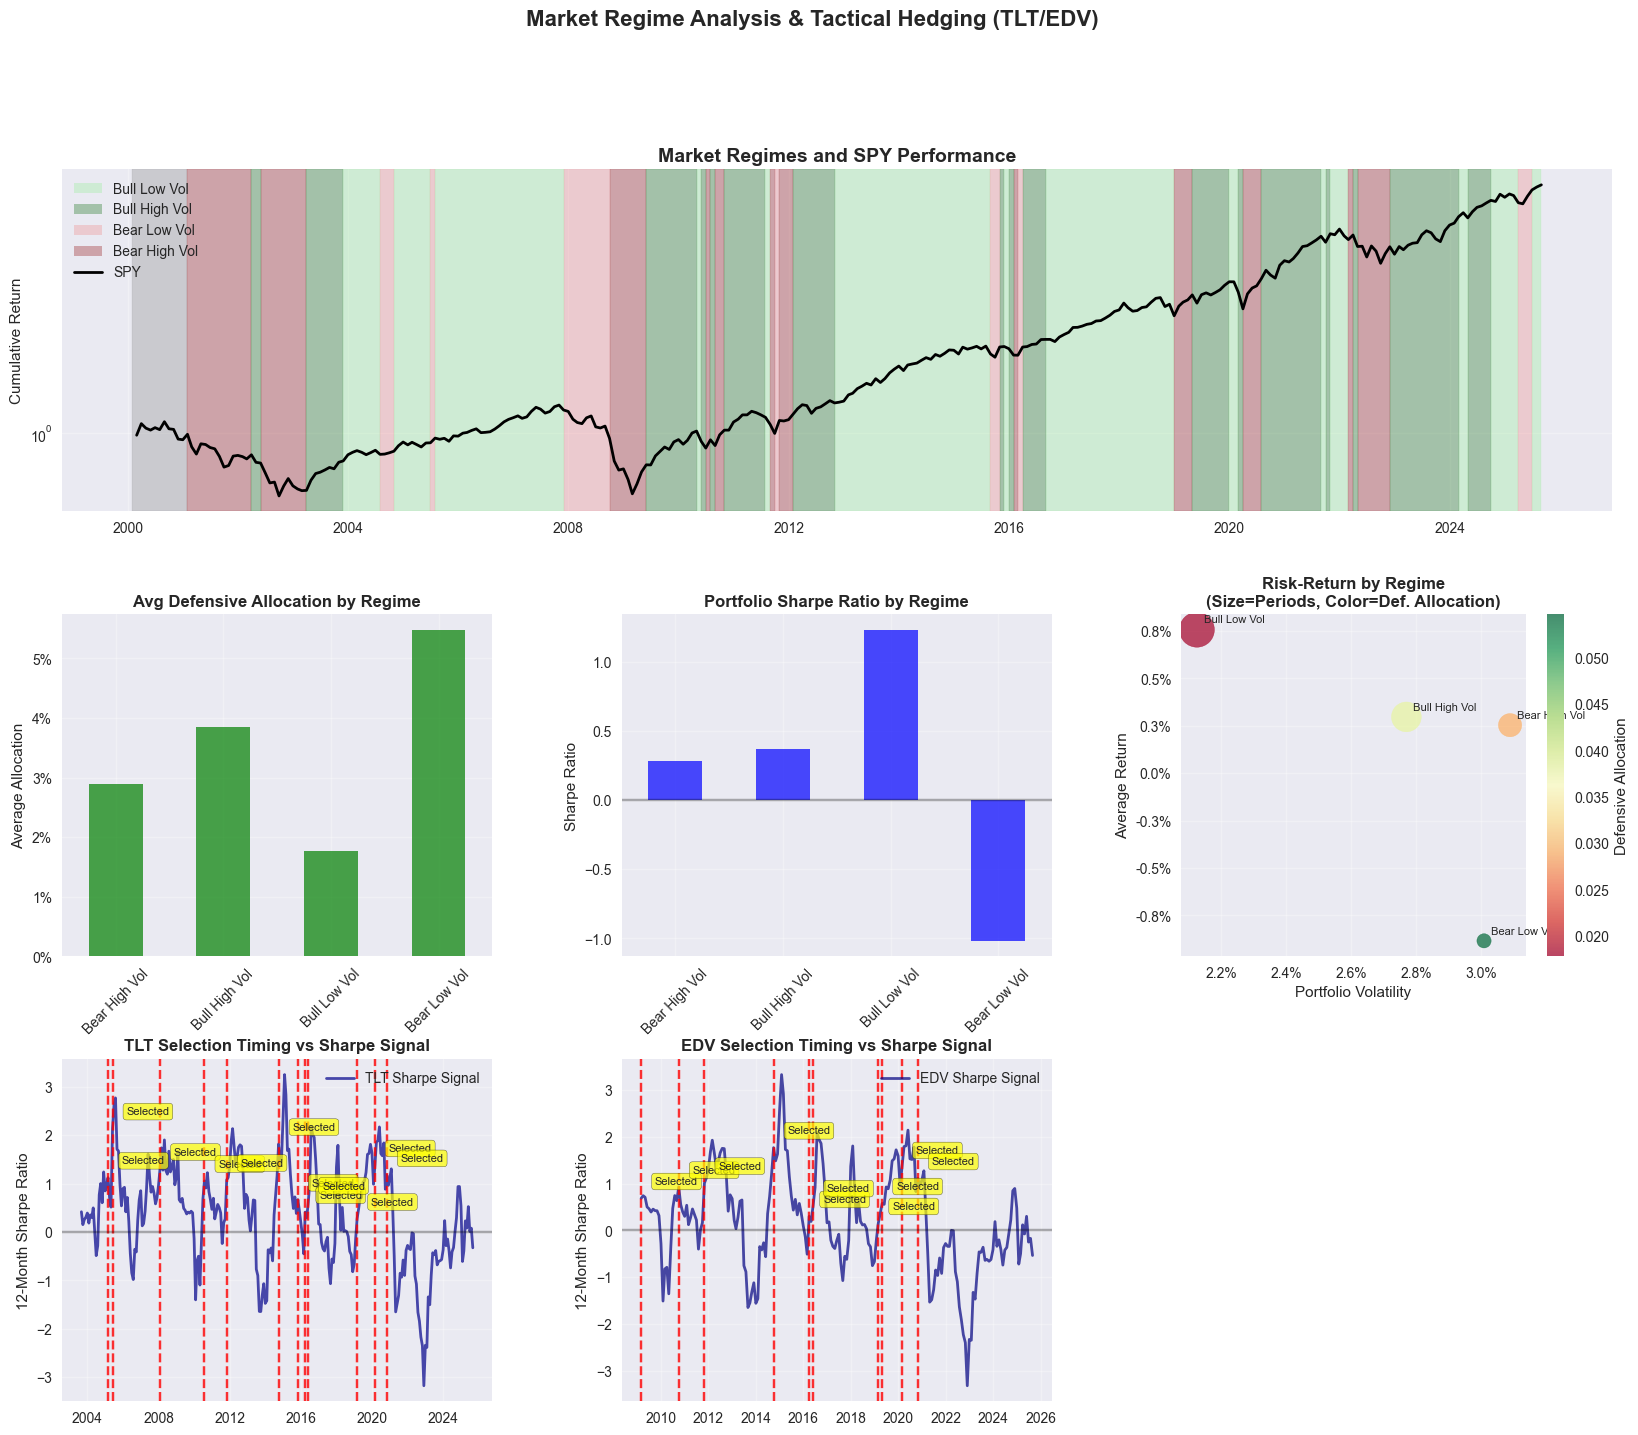


MARKET REGIME HEDGING ANALYSIS (TLT/EDV):
              periods avg_defensive_allocation avg_risk_allocation avg_return volatility sharpe defensive_correlation
Bear High Vol      56                     2.9%               38.7%      0.25%      3.09%  0.284                -0.226
Bull High Vol      92                     3.8%               42.4%      0.30%      2.77%  0.372                -0.010
Bull Low Vol      127                     1.8%               64.4%      0.76%      2.13%  1.234                -0.036
Bear Low Vol       21                     5.5%               44.2%     -0.88%      3.01% -1.018                 0.199

REGIME TRANSITION MATRIX:
----------------------------------------
col_0          Bear High Vol  Bear Low Vol  Bull High Vol  Bull Low Vol  \
row_0                                                                     
Bear High Vol             44             2             10             0   
Bear Low Vol               2            14              2             3   

In [7]:
# Market regime analysis and tactical hedging insights - UPDATED FOR TLT/EDV
def identify_market_regimes(returns, vol_window=12, trend_window=6):
    """Identify market regimes based on volatility and trend"""
    # Calculate rolling volatility and trend
    rolling_vol = returns.rolling(vol_window).std() * np.sqrt(12)
    rolling_trend = returns.rolling(trend_window).mean() * 12

    # Define regime thresholds
    vol_median = rolling_vol.median()
    trend_threshold = 0.0  # Zero as neutral point

    # Classify regimes
    regimes = pd.Series(index=returns.index, dtype='object')

    for date in returns.index:
        if date in rolling_vol.index and date in rolling_trend.index:
            vol = rolling_vol[date]
            trend = rolling_trend[date]

            if pd.isna(vol) or pd.isna(trend):
                regimes[date] = 'Unknown'
            elif trend > trend_threshold and vol < vol_median:
                regimes[date] = 'Bull Low Vol'
            elif trend > trend_threshold and vol >= vol_median:
                regimes[date] = 'Bull High Vol'
            elif trend <= trend_threshold and vol < vol_median:
                regimes[date] = 'Bear Low Vol'
            else:
                regimes[date] = 'Bear High Vol'

    return regimes, rolling_vol, rolling_trend

def analyze_regime_hedging(regimes, defensive_allocation, risk_allocation, returns):
    """Analyze hedging effectiveness across market regimes"""
    regime_analysis = {}

    for regime in regimes.unique():
        if regime != 'Unknown':
            regime_mask = regimes == regime

            if regime_mask.sum() > 0:
                regime_defensive = defensive_allocation[regime_mask]
                regime_risk = risk_allocation[regime_mask]
                regime_returns = returns[regime_mask]

                regime_analysis[regime] = {
                    'periods': regime_mask.sum(),
                    'avg_defensive_allocation': regime_defensive.mean(),
                    'avg_risk_allocation': regime_risk.mean(),
                    'avg_return': regime_returns.mean(),
                    'volatility': regime_returns.std(),
                    'sharpe': regime_returns.mean() / regime_returns.std() * np.sqrt(12) if regime_returns.std() > 0 else 0,
                    'defensive_correlation': regime_defensive.corr(regime_returns) if len(regime_defensive) > 2 else np.nan
                }

    return pd.DataFrame(regime_analysis).T

def calculate_tactical_timing(weights, momentum_signals, defensive_assets, lookback=3):
    """Analyze tactical timing of defensive asset selection"""
    timing_analysis = []

    for asset in defensive_assets:
        if asset in weights.columns and asset in momentum_signals.columns:
            asset_weights = weights[asset]
            asset_signals = momentum_signals[asset]

            # Identify selection/deselection events
            selections = (asset_weights > 0) & (asset_weights.shift(1) == 0)
            deselections = (asset_weights == 0) & (asset_weights.shift(1) > 0)

            # Analyze market conditions around selection
            for date in selections[selections].index:
                # Look at market stress indicators around selection
                period_start = max(0, asset_signals.index.get_loc(date) - lookback)
                period_end = min(len(asset_signals), asset_signals.index.get_loc(date) + lookback + 1)

                period_signals = asset_signals.iloc[period_start:period_end]

                if len(period_signals) > 0:
                    timing_analysis.append({
                        'asset': asset,
                        'date': date,
                        'event': 'selection',
                        'signal_at_selection': asset_signals[date] if date in asset_signals.index else np.nan,
                        'signal_trend': period_signals.mean(),
                        'signal_improvement': period_signals.iloc[-1] - period_signals.iloc[0] if len(period_signals) > 1 else np.nan
                    })

    return pd.DataFrame(timing_analysis)

if spy_returns is not None:
    print("Analyzing market regimes and tactical hedging (TLT/EDV focus)...")

    # Identify market regimes
    regimes, rolling_vol, rolling_trend = identify_market_regimes(spy_returns)

    # Analyze hedging effectiveness by regime
    portfolio_returns_clean = portfolio_returns.dropna()
    regime_hedging = analyze_regime_hedging(regimes, defensive_allocation, risk_allocation, portfolio_returns_clean)

    # Tactical timing analysis for TLT and EDV
    timing_df = calculate_tactical_timing(weights_clean, results['momentum_signals'], available_hedging)

    # Create comprehensive regime analysis visualization
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Plot 1: Market regimes over time
    ax1 = fig.add_subplot(gs[0, :])

    # Color code regimes
    regime_colors = {
        'Bull Low Vol': 'lightgreen',
        'Bull High Vol': 'darkgreen',
        'Bear Low Vol': 'lightcoral',
        'Bear High Vol': 'darkred',
        'Unknown': 'gray'
    }

    cum_spy = (1 + spy_returns).cumprod()
    ax1.plot(cum_spy.index, cum_spy, linewidth=2, color='black', label='SPY Cumulative Return')

    # Add regime background colors
    current_regime = None
    start_date = None

    for date, regime in regimes.items():
        if regime != current_regime:
            if start_date is not None and current_regime in regime_colors:
                ax1.axvspan(start_date, date, alpha=0.3, color=regime_colors[current_regime])
            start_date = date
            current_regime = regime

    # Handle last regime
    if start_date is not None and current_regime in regime_colors:
        ax1.axvspan(start_date, regimes.index[-1], alpha=0.3, color=regime_colors[current_regime])

    ax1.set_title('Market Regimes and SPY Performance', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Cumulative Return')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    # Add legend for regimes
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, alpha=0.3, label=regime)
                      for regime, color in regime_colors.items() if regime != 'Unknown']
    legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=2, label='SPY'))
    ax1.legend(handles=legend_elements, loc='upper left')

    # Plot 2: Defensive allocation by regime
    ax2 = fig.add_subplot(gs[1, 0])
    if not regime_hedging.empty:
        regime_hedging['avg_defensive_allocation'].plot(kind='bar', ax=ax2, color='green', alpha=0.7)
        ax2.set_title('Avg Defensive Allocation by Regime', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Average Allocation')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Plot 3: Sharpe ratio by regime
    ax3 = fig.add_subplot(gs[1, 1])
    if not regime_hedging.empty:
        regime_hedging['sharpe'].plot(kind='bar', ax=ax3, color='blue', alpha=0.7)
        ax3.set_title('Portfolio Sharpe Ratio by Regime', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Sharpe Ratio')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
        ax3.axhline(0, color='black', linestyle='-', alpha=0.3)

    # Plot 4: Volatility vs return by regime
    ax4 = fig.add_subplot(gs[1, 2])
    if not regime_hedging.empty:
        scatter = ax4.scatter(regime_hedging['volatility'], regime_hedging['avg_return'],
                            s=regime_hedging['periods']*5, alpha=0.7,
                            c=regime_hedging['avg_defensive_allocation'], cmap='RdYlGn')

        # Add regime labels
        for regime, row in regime_hedging.iterrows():
            ax4.annotate(regime, (row['volatility'], row['avg_return']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

        ax4.set_xlabel('Portfolio Volatility')
        ax4.set_ylabel('Average Return')
        ax4.set_title('Risk-Return by Regime\n(Size=Periods, Color=Def. Allocation)', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        plt.colorbar(scatter, ax=ax4, label='Defensive Allocation')

    # Plot 5: TLT and EDV selection timing if available
    if not timing_df.empty:
        ax5 = fig.add_subplot(gs[2, 0])
        ax6 = fig.add_subplot(gs[2, 1])
        
        # TLT timing analysis
        if 'TLT' in timing_df['asset'].values:
            tlt_timing = timing_df[timing_df['asset'] == 'TLT']
            tlt_signals = results['momentum_signals']['TLT'] if 'TLT' in results['momentum_signals'].columns else None
            
            if tlt_signals is not None:
                ax5.plot(tlt_signals.index, tlt_signals, linewidth=2, color='darkblue', alpha=0.7, label='TLT Sharpe Signal')
                
                # Mark selection events
                for _, event in tlt_timing.iterrows():
                    ax5.axvline(event['date'], color='red', linestyle='--', alpha=0.8)
                    ax5.annotate('Selected', (event['date'], event['signal_at_selection']),
                               xytext=(10, 10), textcoords='offset points', fontsize=8,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                
                ax5.axhline(0, color='black', linestyle='-', alpha=0.3)
                ax5.set_title('TLT Selection Timing vs Sharpe Signal', fontsize=12, fontweight='bold')
                ax5.set_ylabel('12-Month Sharpe Ratio')
                ax5.legend()
                ax5.grid(True, alpha=0.3)
        
        # EDV timing analysis
        if 'EDV' in timing_df['asset'].values:
            edv_timing = timing_df[timing_df['asset'] == 'EDV']
            edv_signals = results['momentum_signals']['EDV'] if 'EDV' in results['momentum_signals'].columns else None
            
            if edv_signals is not None:
                ax6.plot(edv_signals.index, edv_signals, linewidth=2, color='navy', alpha=0.7, label='EDV Sharpe Signal')
                
                # Mark selection events
                for _, event in edv_timing.iterrows():
                    ax6.axvline(event['date'], color='red', linestyle='--', alpha=0.8)
                    ax6.annotate('Selected', (event['date'], event['signal_at_selection']),
                               xytext=(10, 10), textcoords='offset points', fontsize=8,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                
                ax6.axhline(0, color='black', linestyle='-', alpha=0.3)
                ax6.set_title('EDV Selection Timing vs Sharpe Signal', fontsize=12, fontweight='bold')
                ax6.set_ylabel('12-Month Sharpe Ratio')
                ax6.legend()
                ax6.grid(True, alpha=0.3)

    plt.suptitle('Market Regime Analysis & Tactical Hedging (TLT/EDV)', fontsize=16, fontweight='bold')
    plt.show()

    # Print regime analysis results
    print("\nMARKET REGIME HEDGING ANALYSIS (TLT/EDV):")
    print("=" * 60)

    if not regime_hedging.empty:
        print(regime_hedging.to_string(formatters={
            'avg_defensive_allocation': '{:.1%}'.format,
            'avg_risk_allocation': '{:.1%}'.format,
            'avg_return': '{:.2%}'.format,
            'volatility': '{:.2%}'.format,
            'sharpe': '{:.3f}'.format,
            'defensive_correlation': '{:.3f}'.format,
            'periods': '{:.0f}'.format
        }))

    # Regime transition analysis
    regime_transitions = pd.crosstab(regimes.shift(1), regimes, margins=True)
    print(f"\nREGIME TRANSITION MATRIX:")
    print("-" * 40)
    print(regime_transitions)

    # Tactical timing insights for TLT and EDV
    if not timing_df.empty:
        print(f"\nTACTICAL TIMING ANALYSIS (TLT/EDV):")
        print("-" * 40)

        timing_summary = timing_df.groupby('asset').agg({
            'date': 'count',
            'signal_at_selection': 'mean',
            'signal_trend': 'mean',
            'signal_improvement': 'mean'
        }).rename(columns={'date': 'selection_events'})

        print(timing_summary.to_string(formatters={
            'selection_events': '{:.0f}'.format,
            'signal_at_selection': '{:.3f}'.format,
            'signal_trend': '{:.3f}'.format,
            'signal_improvement': '{:.3f}'.format
        }))

        print(f"\nKEY INSIGHTS (ULTRA-LONG DURATION STRATEGY):")
        print("-" * 35)
        for asset in ['TLT', 'EDV']:
            if asset in timing_summary.index:
                asset_stats = timing_summary.loc[asset]
                print(f"{asset} selected {asset_stats['selection_events']:.0f} times")
                print(f"  Average signal at selection: {asset_stats['signal_at_selection']:.3f}")
                print(f"  Signal improving trend: {asset_stats['signal_improvement']:.3f}")

else:
    print("Warning: SPY data not available for regime analysis")

## Portfolio Decomposition & Risk Attribution

Calculating portfolio attribution (TLT/EDV universe)...
Defensive assets for attribution: 2 - ['TLT', 'EDV']
Risk assets for attribution: 30
Intermediate assets for attribution: 31


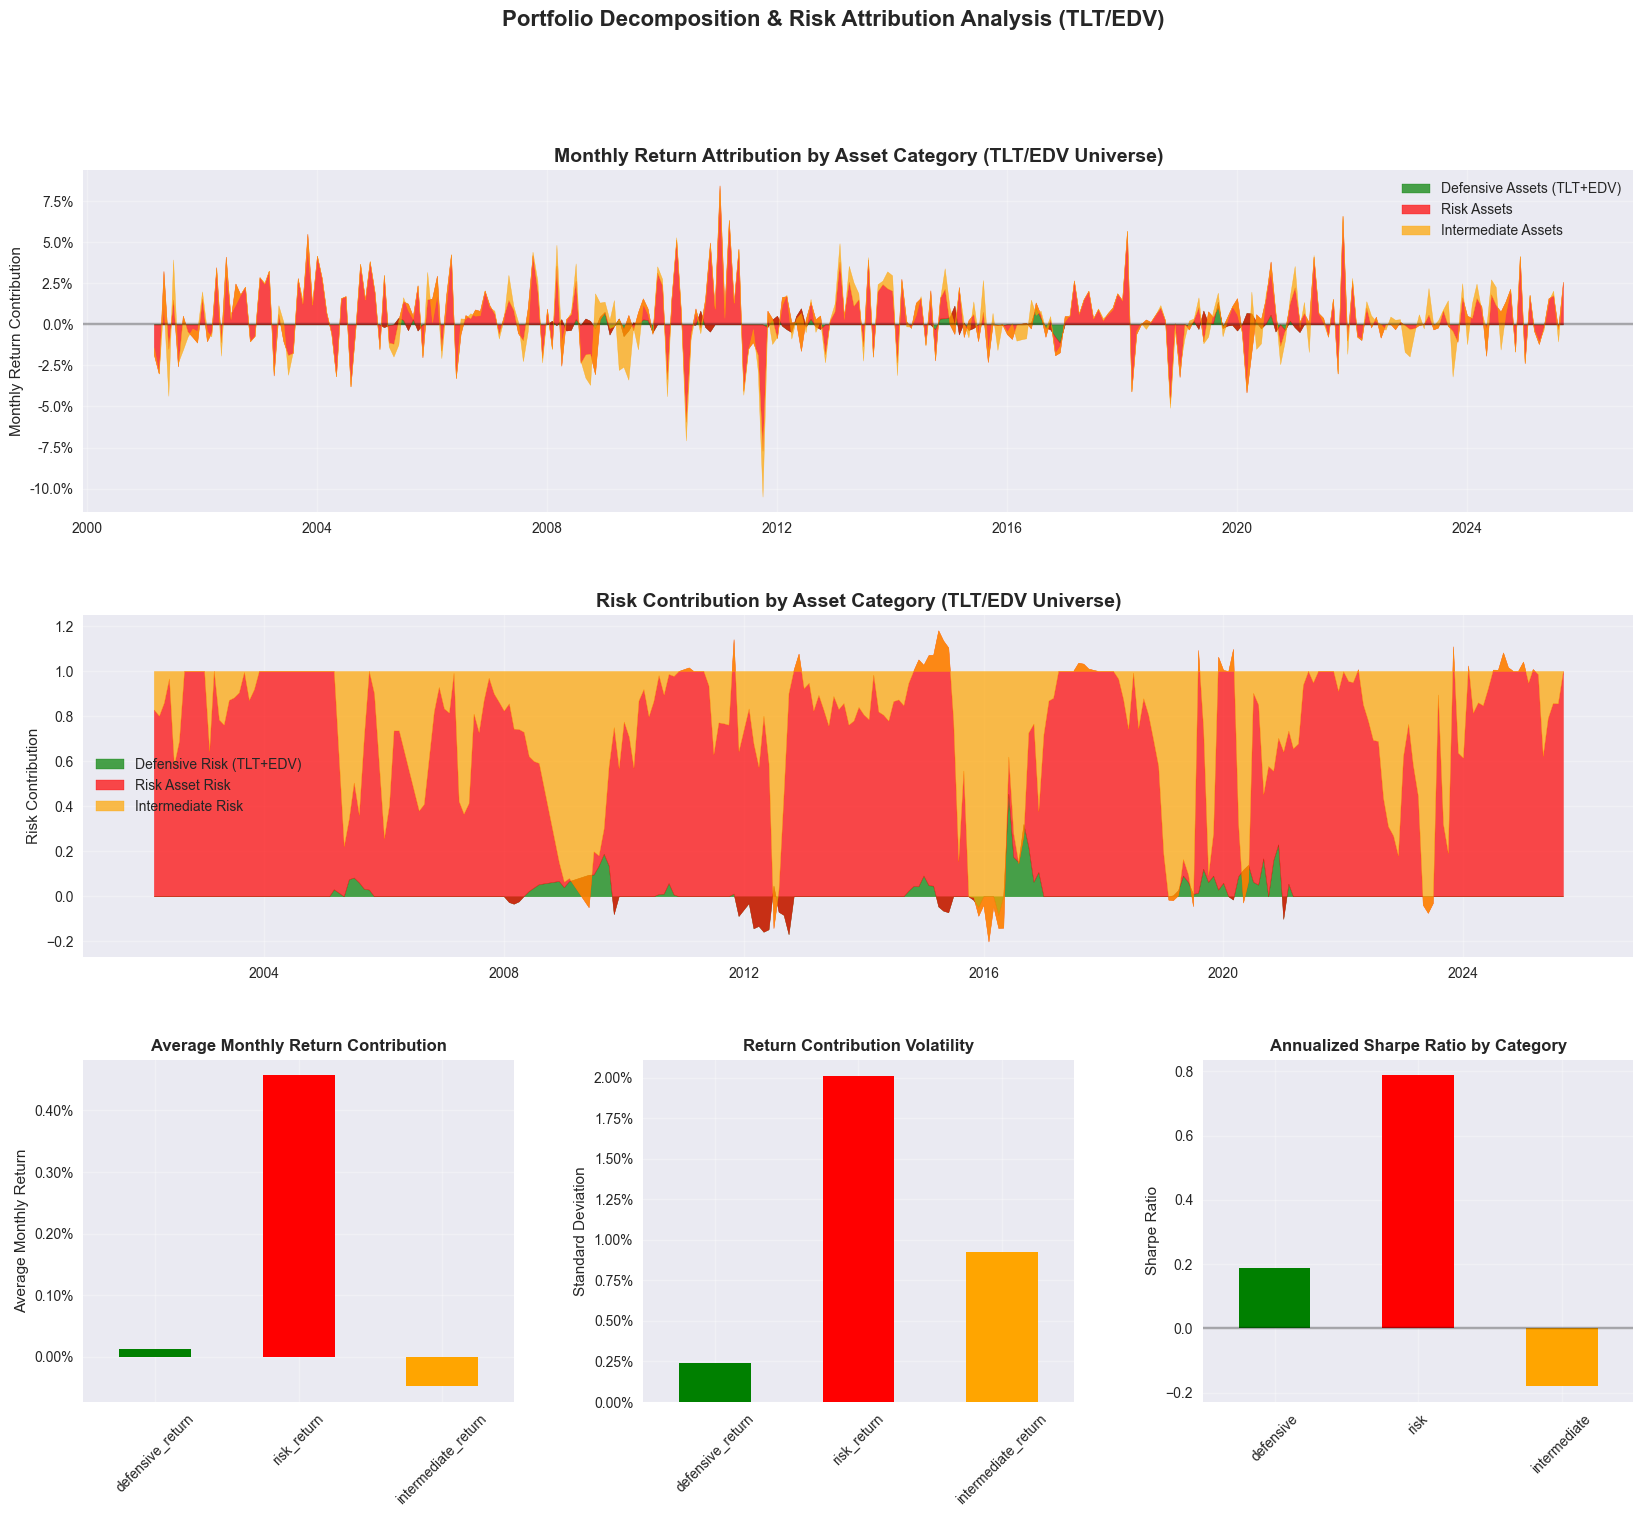


PORTFOLIO ATTRIBUTION ANALYSIS (TLT/EDV UNIVERSE):
RETURN ATTRIBUTION STATISTICS:
----------------------------------------
                    Mean Return Return Volatility Sharpe Ratio Avg Weight
Defensive (TLT+EDV)         NaN               NaN        0.188        NaN
Risk                        NaN               NaN        0.788        NaN
Intermediate                NaN               NaN       -0.180        NaN

RISK ATTRIBUTION STATISTICS:
----------------------------------------
                    Mean Risk Contribution Risk Contrib Volatility Portfolio Vol Impact
Defensive (TLT+EDV)                    NaN                     NaN                  NaN
Risk                                   NaN                     NaN                  NaN
Intermediate                           NaN                     NaN                  NaN

Average Portfolio Volatility: 8.77%

TLT SPECIFIC ATTRIBUTION:
------------------------------
Average TLT Weight (when held): 7.1%
Average Monthly Contribut

In [8]:
# Portfolio decomposition and risk attribution analysis - UPDATED FOR TLT/EDV
def calculate_portfolio_attribution(weights, returns, asset_categories):
    """Calculate return and risk attribution by asset category"""
    attribution_data = []

    for date in weights.index:
        if weights.loc[date].sum() > 0:
            date_weights = weights.loc[date]
            date_returns = returns.loc[date] if date in returns.index else pd.Series(0, index=weights.columns)

            # Calculate category attributions
            defensive_weight = date_weights[asset_categories['defensive']].sum()
            risk_weight = date_weights[asset_categories['risk']].sum()
            intermediate_weight = date_weights[asset_categories['intermediate']].sum()

            defensive_return = (date_weights[asset_categories['defensive']] * date_returns[asset_categories['defensive']]).sum()
            risk_return = (date_weights[asset_categories['risk']] * date_returns[asset_categories['risk']]).sum()
            intermediate_return = (date_weights[asset_categories['intermediate']] * date_returns[asset_categories['intermediate']]).sum()

            total_return = defensive_return + risk_return + intermediate_return

            attribution_data.append({
                'date': date,
                'defensive_weight': defensive_weight,
                'risk_weight': risk_weight,
                'intermediate_weight': intermediate_weight,
                'defensive_return': defensive_return,
                'risk_return': risk_return,
                'intermediate_return': intermediate_return,
                'total_return': total_return,
                'defensive_contribution': defensive_return / total_return if total_return != 0 else 0,
                'risk_contribution': risk_return / total_return if total_return != 0 else 0,
                'intermediate_contribution': intermediate_return / total_return if total_return != 0 else 0
            })

    return pd.DataFrame(attribution_data).set_index('date')

def calculate_risk_decomposition(weights, returns, lookback=12):
    """Calculate portfolio risk decomposition"""
    risk_decomp = []

    for i in range(lookback, len(weights)):
        date = weights.index[i]

        if weights.iloc[i].sum() > 0:
            # Get current weights
            current_weights = weights.iloc[i]
            selected_assets = current_weights[current_weights > 0].index

            # Get historical returns for risk calculation
            hist_returns = returns.iloc[i-lookback:i][selected_assets]

            if len(hist_returns) > 5:  # Minimum observations
                # Calculate covariance matrix
                cov_matrix = hist_returns.cov() * 12  # Annualized

                # Portfolio variance
                w = current_weights[selected_assets]
                portfolio_var = w.T @ cov_matrix @ w

                if portfolio_var > 0:
                    # Marginal risk contributions
                    marginal_risk = cov_matrix @ w
                    risk_contrib = w * marginal_risk / portfolio_var

                    # Categorize risk contributions
                    defensive_risk = risk_contrib[risk_contrib.index.isin(defensive_assets)].sum()
                    risk_asset_risk = risk_contrib[risk_contrib.index.isin(risk_assets)].sum()
                    intermediate_risk = risk_contrib[risk_contrib.index.isin(intermediate_assets)].sum()

                    risk_decomp.append({
                        'date': date,
                        'portfolio_vol': np.sqrt(portfolio_var),
                        'defensive_risk_contrib': defensive_risk,
                        'risk_asset_risk_contrib': risk_asset_risk,
                        'intermediate_risk_contrib': intermediate_risk,
                        'total_risk_contrib': defensive_risk + risk_asset_risk + intermediate_risk
                    })

    return pd.DataFrame(risk_decomp).set_index('date')

# Prepare asset categories for attribution
attribution_categories = {
    'defensive': [asset for asset in defensive_assets if asset in weights.columns],
    'risk': [asset for asset in risk_assets if asset in weights.columns],
    'intermediate': [asset for asset in intermediate_assets if asset in weights.columns]
}

print(f"Calculating portfolio attribution (TLT/EDV universe)...")
print(f"Defensive assets for attribution: {len(attribution_categories['defensive'])} - {attribution_categories['defensive']}")
print(f"Risk assets for attribution: {len(attribution_categories['risk'])}")
print(f"Intermediate assets for attribution: {len(attribution_categories['intermediate'])}")

# Calculate attribution
attribution_df = calculate_portfolio_attribution(weights_clean, monthly_returns, attribution_categories)
risk_decomp_df = calculate_risk_decomposition(weights_clean, monthly_returns)

# Create comprehensive attribution visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Return attribution over time
ax1 = fig.add_subplot(gs[0, :])
ax1.fill_between(attribution_df.index, 0, attribution_df['defensive_return'],
                alpha=0.7, label='Defensive Assets (TLT+EDV)', color='green')
ax1.fill_between(attribution_df.index, attribution_df['defensive_return'],
                attribution_df['defensive_return'] + attribution_df['risk_return'],
                alpha=0.7, label='Risk Assets', color='red')
ax1.fill_between(attribution_df.index,
                attribution_df['defensive_return'] + attribution_df['risk_return'],
                attribution_df['total_return'],
                alpha=0.7, label='Intermediate Assets', color='orange')

ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
ax1.set_title('Monthly Return Attribution by Asset Category (TLT/EDV Universe)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Monthly Return Contribution')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Plot 2: Risk contribution over time
if not risk_decomp_df.empty:
    ax2 = fig.add_subplot(gs[1, :])
    ax2.fill_between(risk_decomp_df.index, 0, risk_decomp_df['defensive_risk_contrib'],
                    alpha=0.7, label='Defensive Risk (TLT+EDV)', color='green')
    ax2.fill_between(risk_decomp_df.index, risk_decomp_df['defensive_risk_contrib'],
                    risk_decomp_df['defensive_risk_contrib'] + risk_decomp_df['risk_asset_risk_contrib'],
                    alpha=0.7, label='Risk Asset Risk', color='red')
    ax2.fill_between(risk_decomp_df.index,
                    risk_decomp_df['defensive_risk_contrib'] + risk_decomp_df['risk_asset_risk_contrib'],
                    risk_decomp_df['total_risk_contrib'],
                    alpha=0.7, label='Intermediate Risk', color='orange')
    
    ax2.set_title('Risk Contribution by Asset Category (TLT/EDV Universe)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Risk Contribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Plot 3: Average return contribution
ax3 = fig.add_subplot(gs[2, 0])
avg_contributions = attribution_df[['defensive_return', 'risk_return', 'intermediate_return']].mean()
avg_contributions.plot(kind='bar', ax=ax3, color=['green', 'red', 'orange'])
ax3.set_title('Average Monthly Return Contribution', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Monthly Return')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

# Plot 4: Return contribution volatility
ax4 = fig.add_subplot(gs[2, 1])
contrib_volatility = attribution_df[['defensive_return', 'risk_return', 'intermediate_return']].std()
contrib_volatility.plot(kind='bar', ax=ax4, color=['green', 'red', 'orange'])
ax4.set_title('Return Contribution Volatility', fontsize=12, fontweight='bold')
ax4.set_ylabel('Standard Deviation')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

# Plot 5: Sharpe ratio by category
ax5 = fig.add_subplot(gs[2, 2])
if not attribution_df.empty:
    category_sharpe = {}
    for category in ['defensive_return', 'risk_return', 'intermediate_return']:
        returns = attribution_df[category]
        if returns.std() > 0:
            category_sharpe[category.replace('_return', '')] = returns.mean() / returns.std() * np.sqrt(12)
        else:
            category_sharpe[category.replace('_return', '')] = 0

    sharpe_series = pd.Series(category_sharpe)
    sharpe_series.plot(kind='bar', ax=ax5, color=['green', 'red', 'orange'])
    ax5.set_title('Annualized Sharpe Ratio by Category', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Sharpe Ratio')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(0, color='black', linestyle='-', alpha=0.3)

plt.suptitle('Portfolio Decomposition & Risk Attribution Analysis (TLT/EDV)', fontsize=16, fontweight='bold')
plt.show()

# Print detailed attribution statistics
print("\nPORTFOLIO ATTRIBUTION ANALYSIS (TLT/EDV UNIVERSE):")
print("=" * 70)
print("RETURN ATTRIBUTION STATISTICS:")
print("-" * 40)
attribution_stats = pd.DataFrame({
    'Mean Return': attribution_df[['defensive_return', 'risk_return', 'intermediate_return']].mean(),
    'Return Volatility': attribution_df[['defensive_return', 'risk_return', 'intermediate_return']].std(),
    'Sharpe Ratio': [attribution_df['defensive_return'].mean() / attribution_df['defensive_return'].std() * np.sqrt(12) if attribution_df['defensive_return'].std() > 0 else 0,
                        attribution_df['risk_return'].mean() / attribution_df['risk_return'].std() * np.sqrt(12) if attribution_df['risk_return'].std() > 0 else 0,
                        attribution_df['intermediate_return'].mean() / attribution_df['intermediate_return'].std() * np.sqrt(12) if attribution_df['intermediate_return'].std() > 0 else 0],
    'Avg Weight': attribution_df[['defensive_weight', 'risk_weight', 'intermediate_weight']].mean()
}, index=['Defensive (TLT+EDV)', 'Risk', 'Intermediate'])

print(attribution_stats.to_string(formatters={
    'Mean Return': '{:.3%}'.format,
    'Return Volatility': '{:.3%}'.format,
    'Sharpe Ratio': '{:.3f}'.format,
    'Avg Weight': '{:.1%}'.format
}))

print("\nRISK ATTRIBUTION STATISTICS:")
print("-" * 40)
risk_stats = pd.DataFrame({
    'Mean Risk Contribution': risk_decomp_df[['defensive_risk_contrib', 'risk_asset_risk_contrib', 'intermediate_risk_contrib']].mean(),
    'Risk Contrib Volatility': risk_decomp_df[['defensive_risk_contrib', 'risk_asset_risk_contrib', 'intermediate_risk_contrib']].std(),
    'Portfolio Vol Impact': risk_decomp_df[['defensive_risk_contrib', 'risk_asset_risk_contrib', 'intermediate_risk_contrib']].mean() * risk_decomp_df['portfolio_vol'].mean()
}, index=['Defensive (TLT+EDV)', 'Risk', 'Intermediate'])

print(risk_stats.to_string(formatters={
    'Mean Risk Contribution': '{:.3f}'.format,
    'Risk Contrib Volatility': '{:.3f}'.format,
    'Portfolio Vol Impact': '{:.2%}'.format
}))

print(f"\nAverage Portfolio Volatility: {risk_decomp_df['portfolio_vol'].mean():.2%}")

# TLT and EDV specific attribution
for asset in ['TLT', 'EDV']:
    if asset in weights_clean.columns and asset in monthly_returns.columns:
        asset_attribution = (weights_clean[asset] * monthly_returns[asset]).dropna()
        asset_weight_avg = weights_clean[asset][weights_clean[asset] > 0].mean()

        print(f"\n{asset} SPECIFIC ATTRIBUTION:")
        print("-" * 30)
        print(f"Average {asset} Weight (when held): {asset_weight_avg:.1%}")
        print(f"Average Monthly Contribution: {asset_attribution.mean():.3%}")
        print(f"Contribution Volatility: {asset_attribution.std():.3%}")
        print(f"Annualized {asset} Sharpe (from contribution): {asset_attribution.mean() / asset_attribution.std() * np.sqrt(12) if asset_attribution.std() > 0 else 0:.3f}")
        print(f"Total {asset} Return Contribution: {asset_attribution.sum():.2%}")